In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import torch
import galsim
import ngmix
from utils.utils import estimate_shear
from utils.utils_ngmix import get_prior

%matplotlib inline

/home/tianaoli/.conda/envs/astro/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng = np.random.RandomState(235)
scale = 0.2 # pixel scale

psf_im = torch.load("psf_23.5_0.pth").numpy()
obs_im = torch.load("obs_23.5_0.pth").numpy()
gt_im = torch.load("gt_23.5_0.pth").numpy()

cen = (np.array(obs_im.shape)-1.0)/2.0
psf_cen = (np.array(psf_im.shape)-1.0)/2.0

jacobian = ngmix.DiagonalJacobian(
    row=cen[0], col=cen[1], scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
    row=psf_cen[0], col=psf_cen[1], scale=scale,
)
    
psf_obs = ngmix.Observation(
    image=psf_im,
    jacobian=psf_jacobian,
)
obs = ngmix.Observation(
    image=obs_im,
    jacobian=jacobian,
    psf=psf_obs,
)

# fit the object to an exponential disk
prior = get_prior(rng=rng, scale=obs.jacobian.scale)
# fit bulge+disk with fixed size ratio, using the levenberg marquards algorithm
fitter = ngmix.fitting.Fitter(model='full', prior=prior)

# _gmix_model_dict = {
#     "full": GMIX_FULL,
#     GMIX_FULL: GMIX_FULL,
#     "gauss": GMIX_GAUSS,
#     GMIX_GAUSS: GMIX_GAUSS,
#     "turb": GMIX_TURB,
#     GMIX_TURB: GMIX_TURB,
#     "exp": GMIX_EXP,
#     GMIX_EXP: GMIX_EXP,
#     "dev": GMIX_DEV,
#     GMIX_DEV: GMIX_DEV,
#     "bdc": GMIX_BDC,
#     GMIX_BDC: GMIX_BDC,
#     "bd": GMIX_BD,
#     GMIX_BD: GMIX_BD,
#     "bdf": GMIX_BDF,
#     GMIX_BDF: GMIX_BDF,
#     GMIX_CM: GMIX_CM,
#     "cm": GMIX_CM,
#     "coellip": GMIX_COELLIP,
#     GMIX_COELLIP: GMIX_COELLIP,
# }

# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=0.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 1
psf_fitter = ngmix.em.EMFitter()
# guesses full gmix objects
psf_guesser = ngmix.guessers.GMixPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=2,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=2,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)

res = boot.go(obs)
rec_im = res.make_image()

KeyError: 0

In [ ]:
gt_shear = estimate_shear(gt_im)
obs_shear = estimate_shear(obs_im)
rec_shear = estimate_shear(rec_im)

print('Ground truth shear (FPFS): ({:.3f},{:.3f})'.format(gt_shear[0], gt_shear[1]))
print('Observed shear (FPFS): ({:.3f},{:.3f})'.format(obs_shear[0], obs_shear[1]))
print('Recovered shear (ngmix): ({:.3f},{:.3f})'.format(res['g'][0],res['g'][1]))
print('Recovered shear (FPFS): ({:.3f},{:.3f})'.format(rec_shear[0], rec_shear[1]))

Ground truth shear (FPFS): (0.270,-0.150)
Observed shear (FPFS): (0.082,-0.057)
Recovered shear (ngmix): (0.126,-0.059)
Recovered shear (FPFS): (0.054,-0.047)


Text(0.5, 1.0, 'Ground truth')

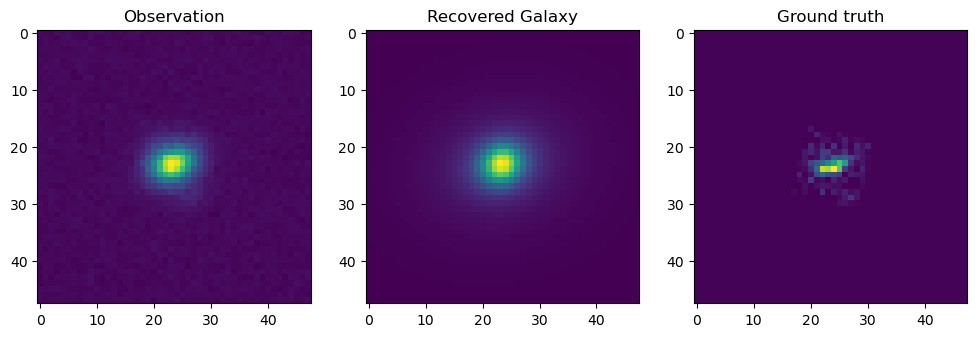

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(obs_im)
plt.title('Observation')

plt.subplot(1,3,2)
plt.imshow(rec_im)
plt.title('Recovered Galaxy')

plt.subplot(1,3,3)
plt.imshow(gt_im)
plt.title('Ground truth')